In [1]:

import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("book_data.csv")
df_temp = pd.read_csv("book_data.csv")

In [3]:
X_desc = df['book_desc']
y_genre = df['genres']

In [4]:
#Convert Genres which are strings to dictionaries in order to obtain values
for i in range(0,54301):
    WordList = ''
    counter = 1
    Word_Dic = {}
    df['genres'][i] = str(df['genres'][i])+'|'
    for k in df['genres'][i]:
        if(k != '|'):
            WordList = WordList+k
        if(k=='|'):
            Word_Dic[counter] = WordList
            counter = counter+1
            WordList = ''
    df['genres'][i] = Word_Dic
      

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
#now that dictionary I can get idividual values of labels
df['genres'][0].values()

dict_values(['Young Adult', 'Fiction', 'Science Fiction', 'Dystopia', 'Fantasy', 'Science Fiction'])

In [6]:
# an empty list
genres = [] 

# extract genres
for i in df['genres']: 
    genres.append(list(i.values())) 

# add to genres dataframe  
df['genre_new'] = genres

In [7]:
df_new = df[~(df['genre_new'].str.len() == 0)]

In [8]:
#get number of unique genres
all_genres = sum(genres,[])
len(set(all_genres))

867

In [9]:
#count all genres
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

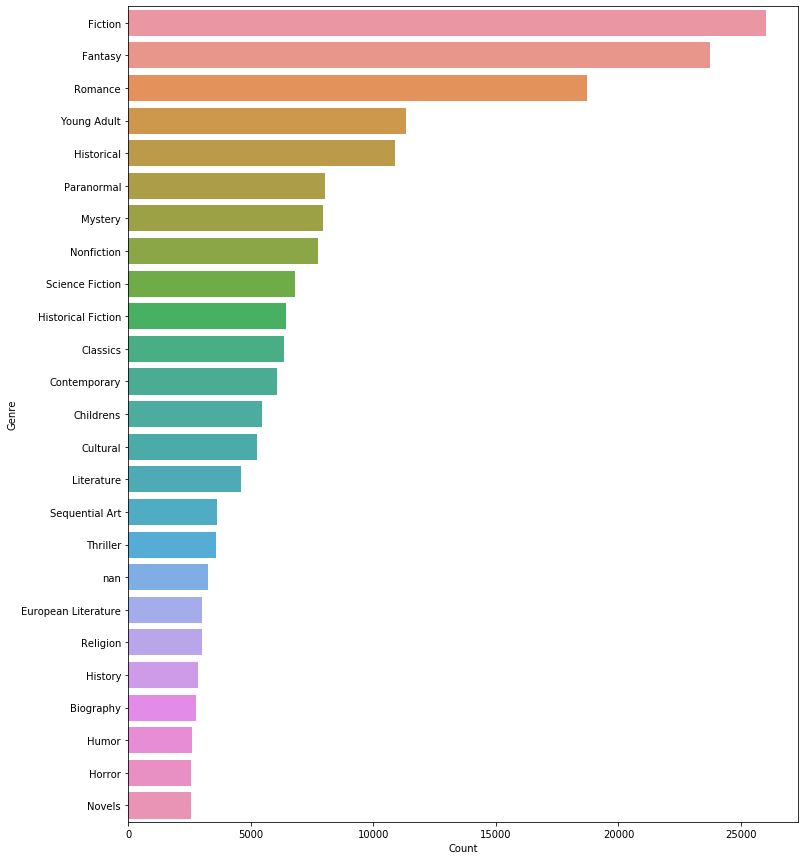

In [10]:
#plot genres to show 50 most frequent genres
g = all_genres_df.nlargest(columns="Count", n = 25) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
plt.show()

In [11]:
# function for text cleaning 
#will remove noisy words from book descriptions
def clean_text(text):
    text = str(text)
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [12]:
#apply clean_text function
df_new['clean_book_desc'] = df_new['book_desc'].apply(lambda x: clean_text(x))

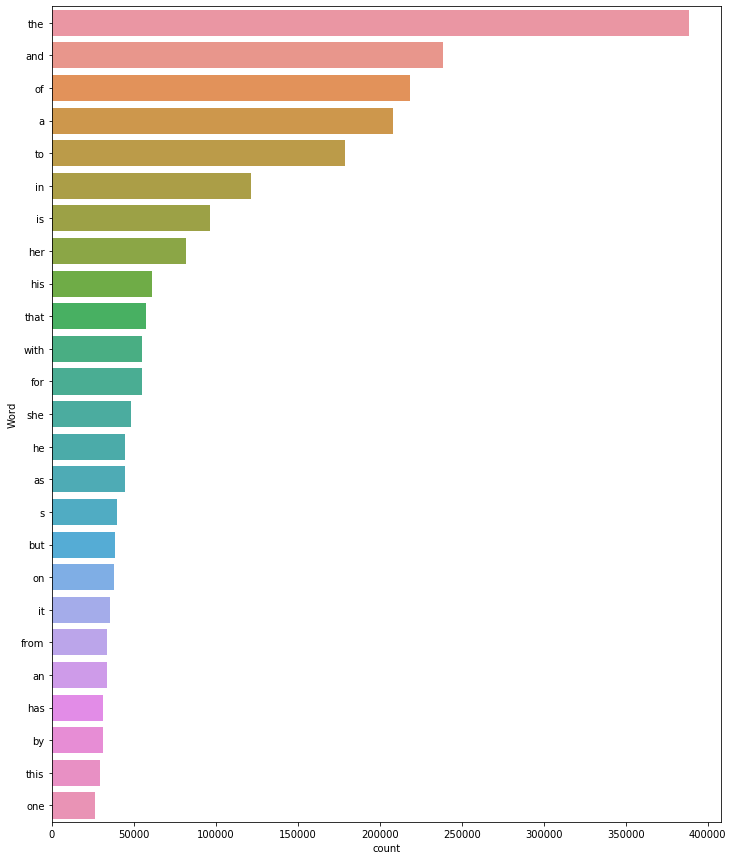

In [13]:
#Plot most frequent words in book description
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
  # print 100 most frequent words 
freq_words(df_new['clean_book_desc'], 25)

In [14]:
#nltk.download('stopwords')

In [15]:
#stop words 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df_new['clean_book_desc']= df_new['clean_book_desc'].apply(lambda x: remove_stopwords(x))

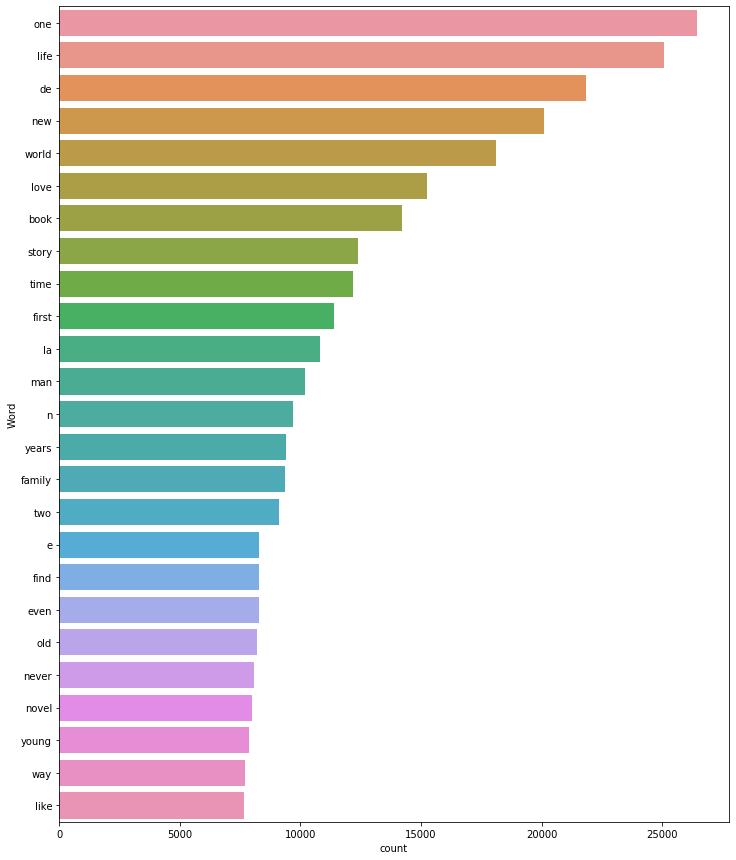

In [16]:
freq_words(df_new['clean_book_desc'], 25)


In [17]:
#convert labels that are dictionaries with multiple values into multilabel columns using mulilabelbinarizer, similar
#to onehotencoding
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(df_new['genre_new'])


In [18]:
import nltk
# nltk.download('punkt')
import string  
from nltk.tokenize import word_tokenize

#going to use word2vec for word embedding, need to tokenize words first to pass them to embedding layer of NN
word_lines = list()
lines = df_new['clean_book_desc'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # dont want token without alphabetic letters
    words = [word for word in stripped if word.isalpha()]
    word_lines.append(words)

In [19]:
#!pip install -U gensim
import gensim 

#now extract features using word2 vec
EMBEDDING_DIM = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=word_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

unable to import 'smart_open.gcs', disabling that module


Vocabulary size: 221319


In [20]:
# save model 
filename = 'books_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [21]:
model.wv.most_similar('happy')#, topn =1)

[('comfortable', 0.8413010239601135),
 ('loving', 0.8346812129020691),
 ('enjoying', 0.8290126919746399),
 ('crazy', 0.8196927905082703),
 ('happier', 0.80824875831604),
 ('nice', 0.8074615001678467),
 ('expect', 0.8053443431854248),
 ('lucky', 0.8034470081329346),
 ('seeing', 0.7996479868888855),
 ('maybe', 0.7987021207809448)]

In [22]:
import os

#load saved model
embeddings_index = {}
f = open(os.path.join('', 'books_word2vec.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [23]:
#will need total number of rows we are 
total_book_desc = df_new['clean_book_desc']
max_length = 100 # try other options like mean of sentence lengths

In [24]:
#here to actually represent our text data in our network we need to convert each word to a unique integer
#This step is crucial in order to be able to properly word embedd
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(word_lines)
sequences = tokenizer_obj.texts_to_sequences(word_lines)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

desc_pad = pad_sequences(sequences, maxlen=max_length)
genres_pad =  df_new['genre_new'].values
print('Shape of review tensor:', desc_pad.shape)
print('Shape of sentiment tensor:', genres_pad.shape)


Found 221319 unique tokens.
Shape of review tensor: (54301, 100)
Shape of sentiment tensor: (54301,)


In [25]:
xtrain, xval, ytrain, yval = train_test_split(desc_pad, y, test_size=0.3, random_state=5)

In [26]:
EMBEDDING_DIM =100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [27]:
print(num_words)

221320


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

# define model
model = Sequential()
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))

#this is our output layer 
model.add(Dense(867, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Using TensorFlow backend.


Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          22132000  
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_1 (Dense)              (None, 867)               28611     
Total params: 22,173,379
Trainable params: 41,379
Non-trainable params: 22,132,000
_________________________________________________________________
None


In [29]:
print('Train...')

history= model.fit(xtrain, ytrain, batch_size=128, epochs=5, validation_data=(xval, yval), verbose=2)

Train...
Train on 38010 samples, validate on 16291 samples
Epoch 1/5
 - 94s - loss: 1476.0422 - accuracy: 0.8378 - val_loss: 0.5526 - val_accuracy: 0.9868
Epoch 2/5
 - 92s - loss: 410.0296 - accuracy: 0.9890 - val_loss: 0.4429 - val_accuracy: 0.9944
Epoch 3/5
 - 70s - loss: 6.8758 - accuracy: 0.9940 - val_loss: 0.3642 - val_accuracy: 0.9944
Epoch 4/5
 - 74s - loss: 1.4116 - accuracy: 0.9942 - val_loss: 0.3017 - val_accuracy: 0.9944
Epoch 5/5
 - 77s - loss: 8.6848 - accuracy: 0.9943 - val_loss: 0.2515 - val_accuracy: 0.9944


In [30]:
# y_pridict = model.predict(xval, verbose=1)

In [31]:
print('Testing...')
score, acc = model.evaluate(xval, yval,  verbose=2)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
Test score: 0.2514995902559023
Test accuracy: 0.9944377541542053
Accuracy: 99.44%


In [32]:
# #Let us test some  samples
# # load the dataset but only keep the top n words, zero the rest

# test_sample_1 = "Winning will make you famous"
# test_sample_2 = "In this fearless and half-crazy story"
# test_sample_3 = "Maybe I like this movie."
# test_sample_4 = "Not to my taste, will skip and watch another movie"
# test_sample_5 = "if you like action, then this movie might be good for you."
# test_sample_6 = "Bad movie!"
# test_sample_7 = "Not a good movie!"
# test_sample_8 = "This movie really sucks! Can I get my money back please?"
# test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8]

# test_samples_tokens = tokenizer_obj.texts_to_sequences(test_samples)
# test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=100)

# #predict
# model.predict(x=test_samples_tokens_pad)

In [33]:
# Testing:
score = model.evaluate(xval, yval, verbose=1)
print('The accuracy is: ', score[1])

16291/16291 [==============================] - ETA:  - ETA:  - ETA:  - ETA: 10 - ETA: 10 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

In [36]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

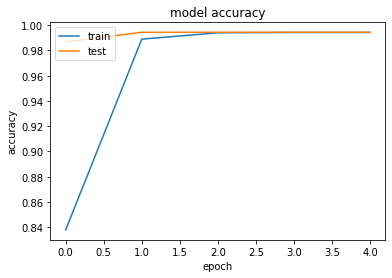

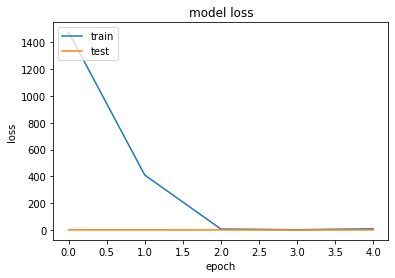

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()